In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
from sklearn.covariance import EmpiricalCovariance
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_score as clust_score
from sklearn.preprocessing import StandardScaler
from scipy import stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
from ipywidgets import interact

# needs to find the library of functions
sys.path.append('../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# a double percentage sign indicates a magic function. in this case, now we are writing this cell in javascript.

In [5]:
NOTEBOOK_NAME = 'time_sync_debug'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [7]:
data_folder = '../data'

In [8]:
traces = np.loadtxt(os.path.join(data_folder, 'C.txt')).T #denoised traces

In [9]:
filename = os.path.join(data_folder, 'behavior_codes.txt')
behavior = ut.read_behavior(filename)
events_list = np.unique([b[1] for b in behavior])

In [10]:
# grab time axis from the xml file

import xml.etree.ElementTree as ET
xmlfile = os.path.join(data_folder, 'tseries.xml')
print "I infer the time axis from:\n", xmlfile
tree = ET.parse(xmlfile)
root = tree.getroot()

# unfortunately we miss the first frame
time_ax = np.r_[[child.attrib['absoluteTime']
                 for child in root.iter('Frame')]].astype(float)

I infer the time axis from:
../data/tseries.xml


In [11]:
# sync times
start_2p = ut.parse_behavior(behavior, 'BEGIN')[0]
behavior = [[float(b[0])-start_2p, b[1]] for b in behavior]
time_ax -= time_ax[0]

In [12]:
# fix behavior event names
behavior = [[b[0], 'TONE_RW' if b[1]=='TONE_PR' else b[1]] for b in behavior]
behavior = [[b[0], 'REWARD' if b[1]=='PRE-REWARD' else b[1]] for b in behavior]

In [13]:
# and centered around tone onset
CYCLE_START = -5  # seconds
CS_DURATION = 2  # seconds
DELAY = 2  # seconds
AFTER_DELAY_DURATION = 4  # seconds
US_START = 4
CYCLE_DURATION = abs(CYCLE_START) + CS_DURATION + DELAY + AFTER_DELAY_DURATION

cycles_starts = ut.parse_behavior(behavior, '^TONE_*', offset=CYCLE_START) #looks for arduino line that begins w/ either 'R' or 'S'
cycles_ends = ut.parse_behavior(behavior, '^TONE_*', offset=CYCLE_DURATION+CYCLE_START)

cycle_subtract = 0   #do we need to subtract off the last cycle because it's too short???
if cycle_subtract !=0:
    cycles = np.r_[zip(cycles_starts,  # offset will be ADDED, with sign
                   cycles_ends)][:cycle_subtract]
else:
    cycles = np.r_[zip(cycles_starts,  # offset will be ADDED, with sign
                   cycles_ends)]

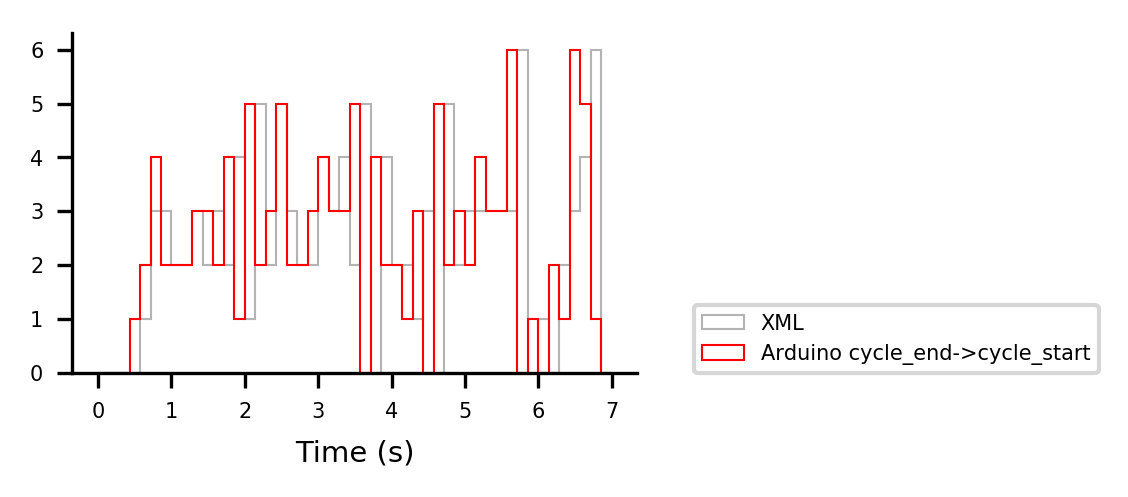

In [14]:
ITIs = np.r_[[sn-ep for ep, sn in zip(cycles_ends, cycles_starts[1:])]]-6

delta_ts = np.diff(time_ax)
pl.hist(delta_ts[delta_ts>0.5], histtype='step', bins=np.linspace(0, 7, 50), color='0.7', lw=0.5);
pl.xlabel('Time (s)')
# pl.vlines(ITIs, 0, 6, 'r', lw=0.5)
# pl.hist(ITIs[ITIs>0.5], histtype='step', bins=50, color='r', lw=0.5);
pl.hist(ITIs[ITIs>0.5], histtype='step', bins=np.linspace(0, 7, 50), color='r', lw=0.5);
pl.legend(['XML', 'Arduino cycle_end->cycle_start'], loc=(1.1, 0))

In [15]:
cycle_starts_from_xml = np.r_[0, time_ax[np.where(np.diff(time_ax)>0.5)[0]+1]]
cycle_starts_from_ard = cycles[:, 0]

(0, 200)

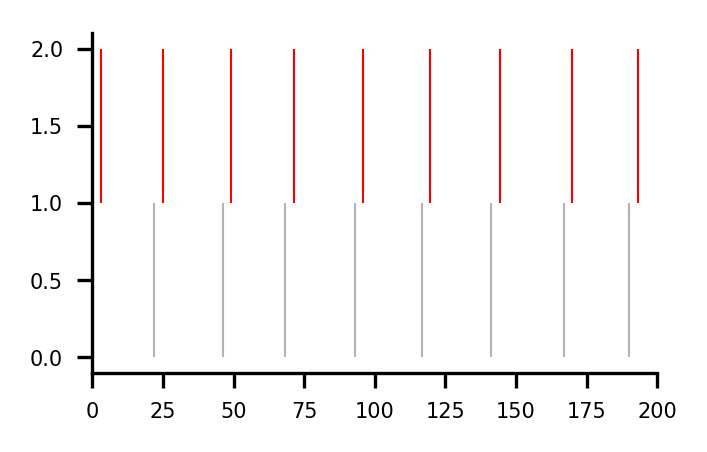

In [16]:
pl.vlines(cycle_starts_from_xml, 0, 1, color='0.7')
pl.vlines(cycle_starts_from_ard, 1, 2, color='r')
pl.xlim(0, 200)